<h1>Содержание<span class="tocSkip"></span></h1>
</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [62]:
import pandas as pd
import os
import matplotlib.pyplot as plt 
import numpy as np
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from statsmodels.tsa.seasonal import seasonal_decompose

In [48]:
path1 = '/datasets/taxi.csv'

path2 = 'taxi.csv'

if os.path.exists(path1):
    taxi_data = pd.read_csv(path1)

elif os.path.exists(path2):
    taxi_data = pd.read_csv(path2)

else:
    print('Something is wrong')

In [49]:
print(taxi_data.head(10))
print(taxi_data.info())
print(taxi_data.describe())

              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32
5  2018-03-01 00:50:00          21
6  2018-03-01 01:00:00           7
7  2018-03-01 01:10:00           5
8  2018-03-01 01:20:00          17
9  2018-03-01 01:30:00          12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


**Общий взгляд на данные**:
- пропусков нет
- данные в столбце выглядят адекватными
- не соответствующий тип данных в 1 столбце 

**Предобработка данных**

In [50]:
#изменим тип данных первой колонки
taxi_data['datetime'] = pd.to_datetime(taxi_data['datetime'])
print(taxi_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None


In [51]:
#установим первую колонку таблицы как индекс и отсортируем по индексу
taxi_data = taxi_data.set_index('datetime',inplace=False)
print(taxi_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [52]:
#отсортируем индекс и проверим, в хронологическом ли порядке расположены даты и время
taxi_data = taxi_data.sort_index(axis=0) 
print(taxi_data.index.is_monotonic)
print(taxi_data.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Ресеплируем данные по одному часу

In [53]:
taxi = taxi_data.resample('1H').sum()

Удалим пустые значения, которые образовались из-за ресемплирования

In [54]:
taxi = taxi.dropna()
print(taxi.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


## Анализ

Рассмотрим график получившейся таблицы

<AxesSubplot:xlabel='datetime'>

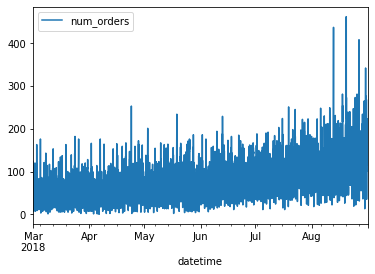

In [55]:
taxi.plot()

Добавим скользящее среднее, чтобы сгладить данные

AxesSubplot(0.125,0.125;0.775x0.755)


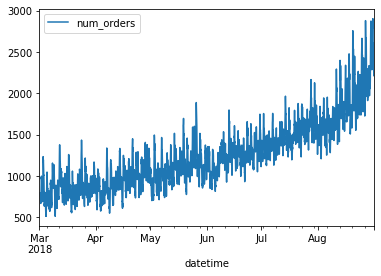

In [56]:
print(taxi.rolling(15).sum().plot())

Пока трудно говорить о какой-то закономерности, пока на графике видно только, что число заказов растет

Рассмотрим тренд и сезонность

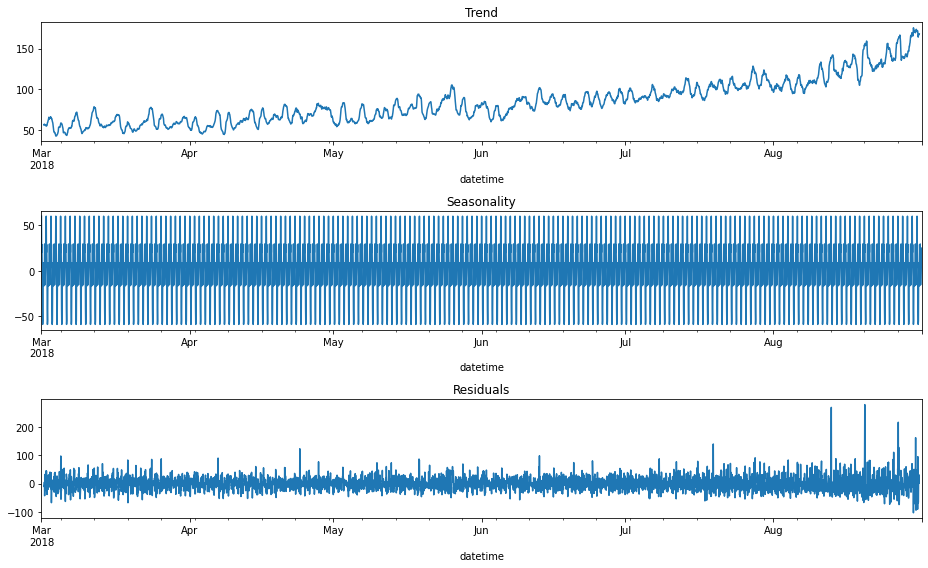

In [57]:
taxi = taxi.dropna()
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(),figsize=(13, 8)) 
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Не первом графике виден тренд к росту заказов такси в час, по сезонности трудно что-то сказать из-за высокой плотности графика. С ростом количества заказов остатков становится все больше по количеству и диапазону. 

## Обучение

Напишем функцию для выделения признаков

In [58]:
def make_features(data, max_lag, rolling_mean_size):
    #df= data.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = round(data['num_orders'].shift(lag),2)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).sum()
    
    #return df

Выделим выборки для обучения и теста.

In [59]:
df = make_features(taxi, 5, 2)

train, test = train_test_split(taxi, shuffle=False, test_size=0.1, random_state = 0)
train, valid = train_test_split(train, shuffle=False, test_size=0.1,random_state = 0)
train = train.dropna()

target_train = train.iloc[:,-1:]
target_valid = valid.iloc[:,-1:]
target_test = test.iloc[:,-1:]

train = train.iloc[:,:-1]
valid = valid.iloc[:,:-1]
test = test.iloc[:,:-1]


In [60]:
print(train.head())

                     num_orders  month  day  dayofweek  hour  lag_1  lag_2  \
datetime                                                                     
2018-03-01 05:00:00           6      3    1          3     5   43.0   66.0   
2018-03-01 06:00:00          12      3    1          3     6    6.0   43.0   
2018-03-01 07:00:00          15      3    1          3     7   12.0    6.0   
2018-03-01 08:00:00          34      3    1          3     8   15.0   12.0   
2018-03-01 09:00:00          69      3    1          3     9   34.0   15.0   

                     lag_3  lag_4  lag_5  
datetime                                  
2018-03-01 05:00:00   71.0   85.0  124.0  
2018-03-01 06:00:00   66.0   71.0   85.0  
2018-03-01 07:00:00   43.0   66.0   71.0  
2018-03-01 08:00:00    6.0   43.0   66.0  
2018-03-01 09:00:00   12.0    6.0   43.0  


**Линейная регрессия**

In [61]:
model_1 = LinearRegression().fit(train,target_train)

pred_1 = model_1.predict(valid) 
score_1 = mean_squared_error(target_valid,pred_1,squared=False)

print("RMSE валидационной выборки:",score_1)

RMSE валидационной выборки: 7.580749551434334e-14


**Дерево решений**

In [64]:
#param_grid
params_for_tree = {'max_depth': np.arange(1,10)}

#модель дерева решений
model_2 = GridSearchCV(DecisionTreeRegressor(random_state = 0),param_grid = params_for_tree, scoring = make_scorer(mean_squared_error, greater_is_better=False), cv=TimeSeriesSplit())

In [65]:
for i in tqdm(range(10)):
    model_2.fit(train,target_train)
    pred_2 = model_2.predict(valid)
    score_2 = mean_squared_error(target_valid, pred_2,squared=False)
print('Оценка RMSE:', score_2)

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

Оценка RMSE: 22.65431321088154


**Случайный лес**

In [67]:
#param_grid
params_for_forest = [{'max_depth': np.arange(1,7)}, {'n_estimators': np.arange(10,51,10)}]

#модель случайного леса
for i in tqdm(range(10)):
    model_3 = GridSearchCV(RandomForestRegressor(random_state = 0),param_grid = params_for_forest, scoring = make_scorer(mean_squared_error, greater_is_better=False), cv=TimeSeriesSplit())

100%|██████████| 10/10 [00:00<00:00, 19143.33it/s]


In [68]:
#train_for = np.ravel(train,'K')
tg_for = np.ravel(target_train)

In [69]:
for i in tqdm(range(10)):
    model_3.fit(train,tg_for)

100%|██████████| 10/10 [02:09<00:00, 12.93s/it]


In [70]:
for i in tqdm(range(10)):
    pred_3 = model_3.predict(valid)
    score_3 = mean_squared_error(target_valid, pred_3,squared=False)

print('Оценка RMSE:', score_3)

100%|██████████| 10/10 [00:00<00:00, 100.33it/s]

Оценка RMSE: 22.826870549759494


## Тестирование

Соберем результаты в таблицу

In [71]:
results = pd.DataFrame([['Линейная регрессия',score_1],
                       ['Дерево решений', score_2],
                       ['Случайный лес',score_3]],
columns = ['Модель', 'RMSE'])
display(results)

,Модель,RMSE
0,Линейная регрессия,7.580750e-14
1,Дерево решений,2.265431e+01
2,Случайный лес,2.282687e+01


Наилучший результат у модели случайного леса. Протестируем наилучшую модель на тестовой выборке.

In [72]:
pred_test= model_3.predict(test)
test_score = mean_squared_error(target_test, pred_test,squared=False)

print('Оценка RMSE:', test_score)

Оценка RMSE: 39.62732104054826


<AxesSubplot:xlabel='datetime'>

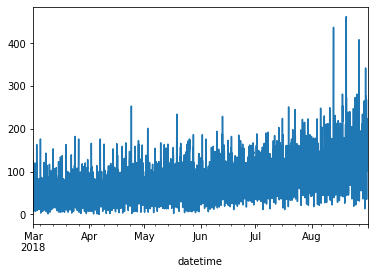

In [87]:
taxi['num_orders'].plot()

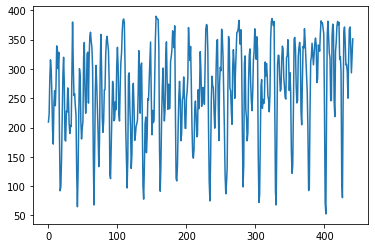

In [85]:
plt.plot(pred_test)
plt.show()

Тестирование на модели случайного леса показало приемлемый результат RMSE.

**Вывод**

Мы загрузили данные по дате и количеству заказов такси. Рассмотрели графики и выявили тендецию и сезонность данных.
Далее мы написали функцию, где выделили обучающие признаки и построили три модели. Наилучший результат RMSE показала модель случайного леса. Тестирование на отдельной выборке дало приемлемый для заказчика результат метрики.